# Path-encoded 4-qubit GHZ states probabilistic generator

This notebook reproduces part of the results in https://arxiv.org/pdf/2211.15626.pdf .

@Author: Mathias Pont (mathias.pont@c2n.upsaclay.fr)<br>
@Affiliation:<br>
Centre for Nanosciences and Nanotechnology, CNRS, Universite Paris-Saclay, UMR 9001,<br>
10 Boulevard Thomas Gobert,<br>
91120 Palaiseau, France<br>

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

In [2]:
import perceval as pcvl

In [3]:
token_qcloud = '<your token cloud>'

In [4]:
def postselect_output(output_state):
    state_list = []
    for m in str(output_state):
        if m.isdigit():
            state_list.append(m)

    state = ''.join(state_list)
    nb_of_result = 4 - state.count('0') + 1
    s = nb_of_result * ['']
    N = []
    c = 1

    for i in range(nb_of_result):
        for party in range(4):
            if int(state[2 * party]) == 0 and int(state[2 * party + 1]) > 0:
                s[i] += '1'
                N.append(int(state[2 * party + 1]))
            if int(state[2 * party]) > 0 and int(state[2 * party + 1]) == 0:
                s[i] += '0'
                N.append(int(state[2 * party]))
            if int(state[2 * party]) > 0 and int(state[2 * party + 1]) > 0:
                if c % 2 == 0:
                    s[i] += '1'
                else:
                    s[i] += '0'
                N.append(int(state[2 * party]) + int(state[2 * party + 1]))
        c += 1

    if len(s) == 0 or len(s[0]) < 4:
        return None, N
    else:
        return s, N

In [5]:
class OpticalCircuit:

    def __init__(self):

        # An outcome is a 4-qubit state in the computational basis.
        self.outcome = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=4))]

        # The circuit is the optical chip
        self.circuit = pcvl.Circuit(m=8, name="GHZ")

        self.phase_shifters = []

        for i in range(1, 9):
            self.phase_shifters.append(pcvl.P(f'phi{i}'))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), pcvl.BS())
        for i in range(3):
            self.circuit.add((2 * i + 1, 2 * i + 2), pcvl.PERM([1, 0]))
        for i in range(4):
            self.circuit.add(2 * i, pcvl.PS(self.phase_shifters[i]))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), pcvl.BS())
        for i in range(4):
            self.circuit.add(2 * i, pcvl.PS(self.phase_shifters[i + 4]))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), pcvl.BS())

        # Measurement defines the 1-qubit Pauli projectors in the path-encoded scheme.
        self.measurement = dict()

        self.measurement['sigmax'] = [0, np.pi / 2]
        self.measurement['sigmay'] = [np.pi/2, np.pi / 2]
        self.measurement['sigmaz'] = [0, np.pi]
        self.measurement['Id'] = [0, np.pi]

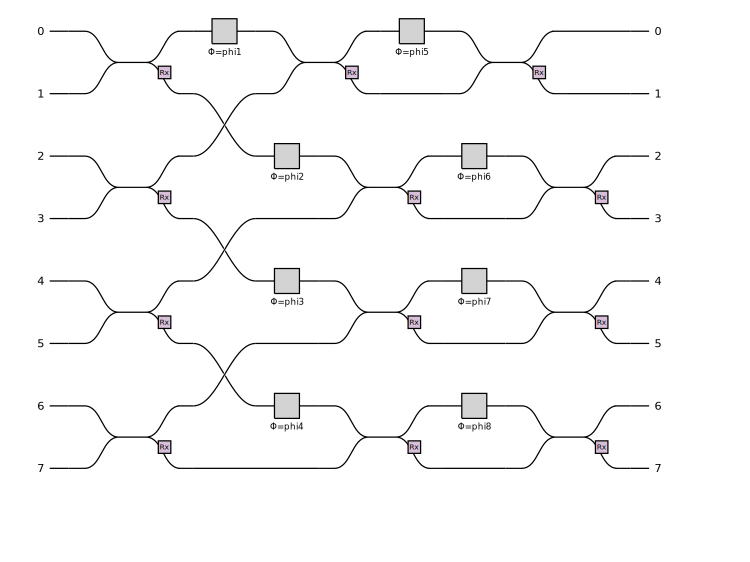

In [6]:
chip = OpticalCircuit()
# Display the interferometer.
from perceval.rendering.circuit import SymbSkin, PhysSkin
pcvl.pdisplay(chip.circuit, skin=SymbSkin())

In [7]:
def compute_remote_async(qpu1: str = "sim:ascella",
                         qpu2: str = "sim:ascella",
                         token_qcloud: str = '<your personal token>',
                         nsamples: float = 500,
                         projector: tuple = ('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')):
    """
    :param qpu1: The first qpu is used to compute the compiled_circuit and the compiled_input
    :param qpu2: The second qpu is used to sample
    :param token_qcloud: Quandela Cloud personal Token
    :param nsamples: Number of 4-photon coincidences (only 1/8 are "usefull" <=> 1 and only 1 photon per qubit)
    :param projector: 4-qubit Pauli projector in a tuple, e.g. ('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')
    :return: async_job, job.id
    """

    chip = OpticalCircuit()

    # set up the phases of the chip corresponding to the 4-qubit Pauli projector
    context_PS = []
    for party in projector:
        context_PS.append(chip.measurement[party])
    # Psi is the first two (phase theta of the GHZ state)
    # Phi is the phases of the MZIs
    c_Psi = 0
    c_Phi = 4
    for phase_party in context_PS:
        chip.phase_shifters[c_Psi].set_value(phase_party[0])
        chip.phase_shifters[c_Phi].set_value(phase_party[1])
        c_Psi += 1
        c_Phi += 1

    input_state = pcvl.BasicState([1, 0, 1, 0, 1, 0, 1, 0])
    circuit = chip.circuit

    # run the circuit on SIMULATOR first
    remote_qpu = pcvl.RemoteProcessor(qpu1, token_qcloud)

    remote_qpu.with_input(input_state)
    remote_qpu.set_circuit(circuit)
    remote_qpu.mode_post_selection(4)

    # synchronous syntax
    sampler = pcvl.algorithm.Sampler(remote_qpu)
    job = sampler.sample_count(nsamples)

    compiled_circuit = job["computed_circuit"]
    compiled_input = job["computed_input"]

    # Used compiled results to run the circuit on the HARDWARE
    remote_qpu = pcvl.RemoteProcessor(qpu2, token_qcloud)

    remote_qpu.with_input(compiled_input)
    remote_qpu.set_circuit(compiled_circuit)
    remote_qpu.mode_post_selection(4)

    # synchronous syntax
    sampler = pcvl.algorithm.Sampler(remote_qpu)
    job = sampler.sample_count

    async_job = job.execute_async(nsamples)

    return async_job, job.id

In [8]:
def get_job_results(qpu, token_qcloud, job_id, projector, normalize=True):
    """
    :param qpu: The qpu used to sample in compute_remote_async()
    :param token_qcloud: Quandela Cloud personal Token
    :param job_id: job_id from which to get the async job
    :param projector: 4-qubit Pauli projector in a tuple, e.g. ('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')
    :param normalize: return emperical table in raw counts, or in probability.
    :return: Perceval job, and emperical table
    """

    remote_processor = pcvl.RemoteProcessor(qpu, token_qcloud)
    job = remote_processor.resume_job(job_id)

    sv_out = job.get_results()["results"]

    empirical_table = {projector: {}}

    for output_state in sv_out:
        all_possible_result, N = postselect_output(output_state)
        if all_possible_result is not None:
            for result in all_possible_result:
                # Initialize the empirical table if this result doesn't exist yet.
                if result not in empirical_table[projector]:
                    empirical_table[projector][result] = sv_out[output_state]
                # Add the probabilility to the result if it has already been created.
                else:
                    empirical_table[projector][result] += sv_out[output_state]

    for outcome in chip.outcome:
        if outcome not in empirical_table[projector]:
            empirical_table[projector][outcome] = 0.0

    norm_factor = np.sum([empirical_table[projector][x] for x in chip.outcome])
    dict_normed = {}
    for outcome in chip.outcome:
        # if the probability is near 0, replace it by 0
        if normalize:
            dict_normed[outcome] = empirical_table[projector][outcome] / norm_factor
        else:
            dict_normed[outcome] = empirical_table[projector][outcome]
    empirical_table[projector] = dict_normed

    return job, empirical_table

In [9]:
# qpu2 can be either "sim:ascella" or "qpu:ascella"
qpu1 = "sim:ascella"
qpu2 = "sim:ascella"

In [10]:
async_jobx, jobx_id = compute_remote_async(qpu1=qpu1,
                                           qpu2=qpu2,
                                           token_qcloud=token_qcloud,
                                           nsamples=2000,
                                           projector=('sigmax', 'sigmax', 'sigmax', 'sigmax'))
async_jobz, jobz_id = compute_remote_async(qpu1=qpu1,
                                           qpu2=qpu2,
                                           token_qcloud=token_qcloud,
                                           nsamples=2000,
                                           projector=('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz'))

In [11]:
# Check if the job is done
print(async_jobx.is_complete)
print(async_jobz.is_complete)

True
True


In [12]:
jobx, XXXX = get_job_results(qpu2,
                             token_qcloud,
                             jobx_id,
                             projector=('sigmax', 'sigmax', 'sigmax', 'sigmax'),
                             normalize=False)
jobz, ZZZZ = get_job_results(qpu2,
                             token_qcloud,
                             jobz_id,
                             projector=('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz'),
                             normalize=False)

/var/folders/90/kj8chdqx4pjgntv02_t1hhk00000gn/T/ipykernel_59998/2848571997.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(XXXX[('sigmax', 'sigmax', 'sigmax', 'sigmax')].keys(), rotation=45, ha='center')
/var/folders/90/kj8chdqx4pjgntv02_t1hhk00000gn/T/ipykernel_59998/2848571997.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ZZZZ[('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')].keys(), rotation=45, ha='center')


[Text(0, 0, '0000'),
 Text(1, 0, '0001'),
 Text(2, 0, '0010'),
 Text(3, 0, '0011'),
 Text(4, 0, '0100'),
 Text(5, 0, '0101'),
 Text(6, 0, '0110'),
 Text(7, 0, '0111'),
 Text(8, 0, '1000'),
 Text(9, 0, '1001'),
 Text(10, 0, '1010'),
 Text(11, 0, '1011'),
 Text(12, 0, '1100'),
 Text(13, 0, '1101'),
 Text(14, 0, '1110'),
 Text(15, 0, '1111')]

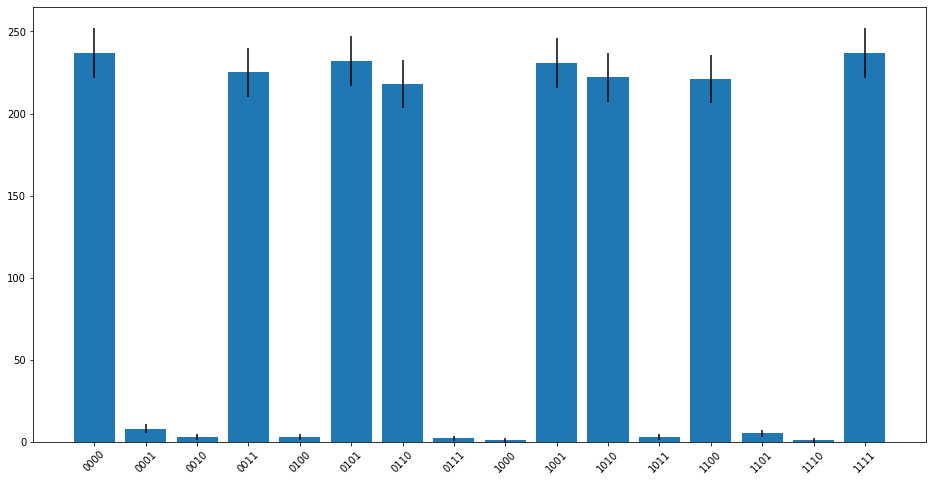

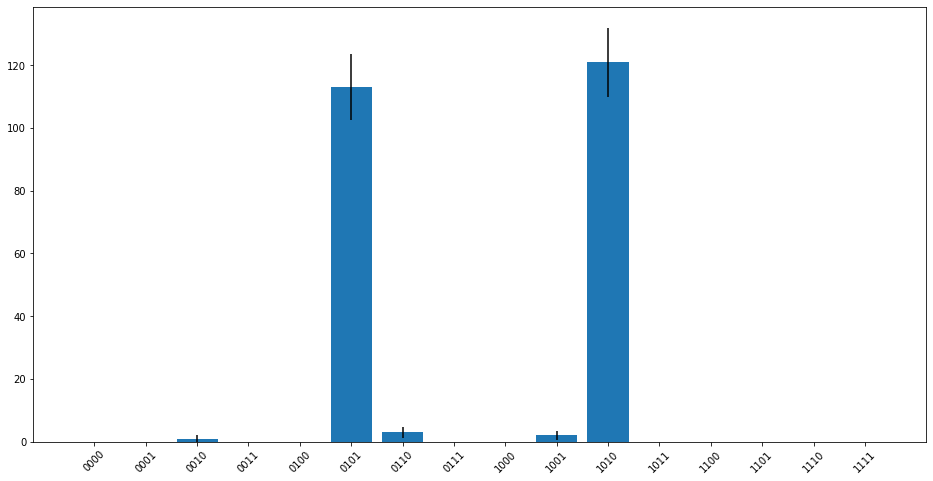

In [13]:
# Plot the raw histograms
fig, ax = plt.subplots()
plt.bar(XXXX[('sigmax', 'sigmax', 'sigmax', 'sigmax')].keys(),
        XXXX[('sigmax', 'sigmax', 'sigmax', 'sigmax')].values(),
        yerr = [np.sqrt(i) for i in XXXX[('sigmax', 'sigmax', 'sigmax', 'sigmax')].values()])
ax.set_xticklabels(XXXX[('sigmax', 'sigmax', 'sigmax', 'sigmax')].keys(), rotation=45, ha='center')

fig, ax = plt.subplots()
plt.bar(ZZZZ[('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')].keys(),
        ZZZZ[('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')].values(),
        yerr = [np.sqrt(i) for i in ZZZZ[('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')].values()])
ax.set_xticklabels(ZZZZ[('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')].keys(), rotation=45, ha='center')

In [14]:
jobx, XXXX = get_job_results(qpu2,
                             token_qcloud,
                             jobx_id,
                             projector=('sigmax', 'sigmax', 'sigmax', 'sigmax'),
                             normalize=True)
jobz, ZZZZ = get_job_results(qpu2,
                             token_qcloud,
                             jobz_id,
                             projector=('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz'),
                             normalize=True)

-0.9431485683414369
0.9715742841707184


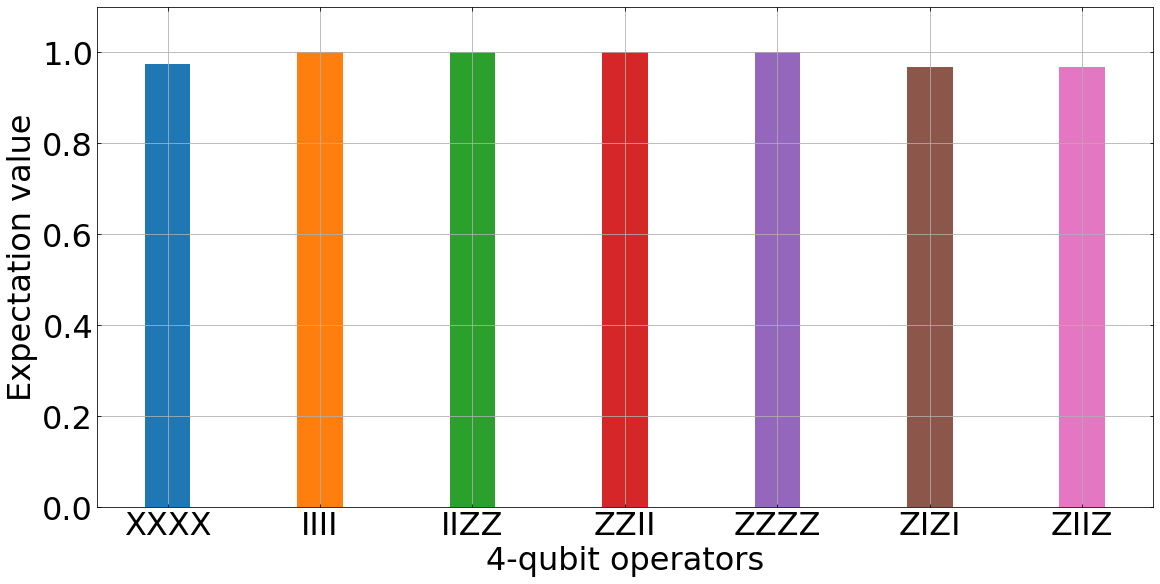

In [17]:
# Plot the stabilizers and compute the witness and the lower bound to the fidelity
def output_state_sign(context, output_state):
    measurement_output = {'0': -1, '1': 1}

    signs_dict = {0: measurement_output,
                  1: measurement_output,
                  2: measurement_output,
                  3: measurement_output
                  }

    # 2 partite context
    if context.count('|') == 2:
        # Find which party are involved
        [party_involved_1, party_involved_2] = [i for i, e in enumerate(list(context)) if e != '|']

        sign_party_involved_1 = signs_dict[party_involved_1][output_state[party_involved_1]]
        sign_party_involved_2 = signs_dict[party_involved_2][output_state[party_involved_2]]
        return int(sign_party_involved_1 * sign_party_involved_2)

    # 4 partite context
    if context.count('|') == 0:
        sign_1 = signs_dict[0][output_state[0]]
        sign_2 = signs_dict[1][output_state[1]]
        sign_3 = signs_dict[2][output_state[2]]
        sign_4 = signs_dict[3][output_state[3]]
        return int(sign_1 * sign_2 * sign_3 * sign_4)

    # 4 partite context
    if context.count('|') == 4:
        return 1

# Compute g1
projector = ('sigmax', 'sigmax', 'sigmax', 'sigmax')
output_bit_string = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=4))]

g1 = 0
for outcome in output_bit_string:
    g1 += XXXX[projector][outcome] * output_state_sign('0000', outcome)


def get_gk(context):
    projector = ('sigmaz', 'sigmaz', 'sigmaz', 'sigmaz')
    output_bit_string = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=4))]

    gk = 0
    for outcome in output_bit_string:
        gk += ZZZZ[projector][outcome] * output_state_sign(context, outcome)

    return gk

sum_gk = (1 +
          abs(get_gk('||11')) +
          abs(get_gk('|11|')) +
          abs(get_gk('|1|1')) +
          abs(get_gk('11||')) +
          abs(get_gk('1111')) +
          abs(get_gk('1|1|')) +
          abs(get_gk('1||1'))
          )

fig, ax = plt.subplots(constrained_layout=True)
# ax.bar(stab_str, stab_exp, width=0.5, label="Computed from histogram")
ax.bar(['XXXX'], g1, width=0.3)
ax.bar(['IIII'], abs(get_gk('||||')), width=0.3)
ax.bar(['IIZZ'], abs(get_gk('||11')), width=0.3)
ax.bar(['ZZII'], abs(get_gk('11||')), width=0.3)
ax.bar(['ZZZZ'], abs(get_gk('1111')), width=0.3)
ax.bar(['ZIZI'], abs(get_gk('1|1|')), width=0.3)
ax.bar(['ZIIZ'], abs(get_gk('1||1')), width=0.3)

ax.grid(True)
ax.set_xlabel('4-qubit operators', fontsize=32)
ax.set_ylabel('Expectation value', fontsize=32)
ax.set_ylim(0, 1.1)
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True, labelsize=32)

W_GHZ = 3 - 2 * ((g1 + 1) / 2 + sum_gk / 8)

print(W_GHZ)
print((1 - W_GHZ) / 2)